In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

#importing libraries for model building and evaluation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Datasets

In [ ]:
# loading the datasets
data1 = pd.read_csv('/content/drive/MyDrive/MAIN PROJECT/Sarcasm data1 (1).csv')
data2 = pd.read_csv('/content/drive/MyDrive/MAIN PROJECT/Sarcasm data2 (1).csv')
data = pd.concat([data1, data2], ignore_index=True)

# Display the concatenated data
print(data.head())


                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


# Data Preprocessing:

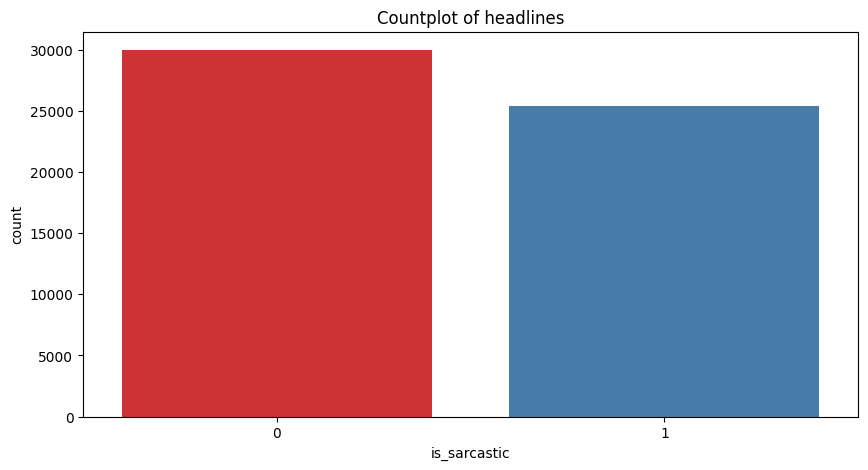

In [ ]:
# Check the dataset label balance or not

# Check number of headlines by is_sarcastics
plt.figure(figsize=(10, 5))
sns.countplot(x='is_sarcastic', data=data, palette="Set1").set_title(
	"Countplot of headlines")
plt.show()


# Data Cleaning:

In [ ]:

#downloading the stopwords corpus list

import nltk

nltk.download('stopwords')
stopwords_list = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean_text(sentences):
	# convert text to lowercase
	text = sentences.lower()
	# remove text in square brackets
	text = re.sub('\[.*?\]', '', text)
	# removing punctuations
	text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
	# removing words containing digits
	text = re.sub('\w*\d\w*', '', text)
	# Join the words
	text = ' '.join([word for word in text.split()
					if word not in stopwords_list])
	return text


print(data['headline'].iloc[1])
clean_text(data['headline'].iloc[1])


the 'roseanne' revival catches up to our thorny political mood, for better and worse


'roseanne revival catches thorny political mood better worse'

In [ ]:
#new column to store cleaned text
data['cleaned_headline']=data['headline'].map(clean_text)


# Wordcloud

Most Frequent Word in Sarcastic Headlines

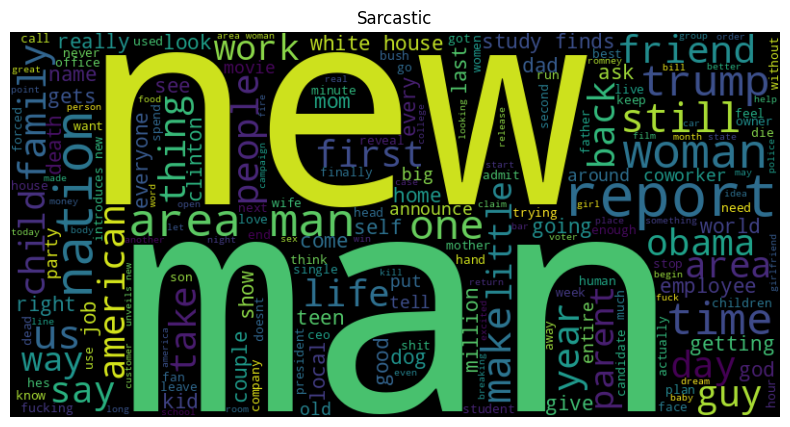

In [ ]:
# Combine all sarcastic cleaned headlines into a single text
import matplotlib.pyplot as plt
from wordcloud import WordCloud
Sarcastic_text = ' '.join(
	data['cleaned_headline'][data['is_sarcastic'] == 1].tolist())

# Import the necessary libraries

# Create a WordCloud object with specified width, height, and background color
wordcloud = WordCloud(width=800, height=400,
					background_color='black').generate(Sarcastic_text)

# Display the WordCloud without axes
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Sarcastic')
plt.show()


# This wordcloud visualization highlights the most common words in the sarcastic headlines.
#  The size of the word in word cloud represents the frequency in the text.


Most Frequent Word in Non-Sarcastic Headlines

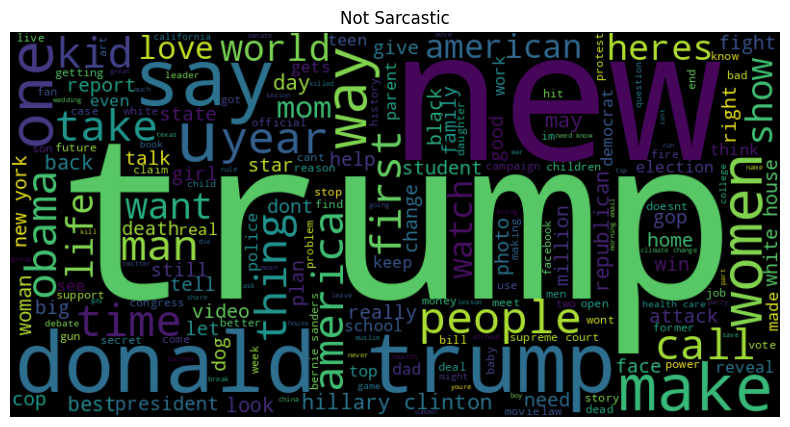

In [ ]:
# Combine all non-sarcastic cleaned headlines into a single text
Non_Sarcastic_text = ' '.join(
	data['cleaned_headline'][data['is_sarcastic'] == 0].tolist())

# Create a WordCloud object with specified width, height, and background color
wordcloud = WordCloud(width=800, height=400,
					background_color='black').generate(Non_Sarcastic_text)

# Display the WordCloud without axes
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Not Sarcastic')
plt.show()


# This wordcloud visualization represents the most common non-sarcastic words in the headlines.

# Splitting Train and test datasets

In [ ]:
#coverting the columns into lists
text = data['cleaned_headline'].tolist()
label = data['is_sarcastic'].tolist()


We will be converting the text into a list containing cleaned headline text and the label into the list containing the corresponding labels where (1 is sarcastic and 0 is non- sarcastic) for each headline in text list.



In [ ]:
# train :test : validation = 80:10:10
train_portion = .8

# Set the train size using training_portion arg
train_size = int(len(text) * train_portion)

# Training dataset
train_text = text[:train_size]
train_label = label[:train_size]
# Validations dataset
valid_size = train_size+int((len(text)-train_size)/2)
val_text = text[train_size:valid_size]
val_label = label[train_size:valid_size]
# Testing dataset
test_text = text[valid_size:]
test_label = label[valid_size:]

# Check
print('Training data :', len(train_text), len(train_label))
print('Validations data :', len(val_text), len(val_label))
print('Testing data :', len(test_text), len(test_label))


Training data : 44262 44262
Validations data : 5533 5533
Testing data : 5533 5533


here we are dividing the dataset into training, testing and validation data according to 80:10:10 split ratio. It calculates the size of the subset, extracting the corresponding text and printing the size of the subset.

In [ ]:
#Now , we will be setting the parameters for training the

# Set parameters
# Max len of unique words
vocab_size = 10000

# Embedding dimension value
embedding_dim = 200

# Max length of sentence
max_length = 60

# pad_sequences arg
padding_type = 'post'

# Unknow words = <OOV>
oov_tok = '<OOV>'

# Tokenizing and padding
# Create a tokenizer with a specified vocabulary size and out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Fit the tokenizer on the training text data to create word-to-index mapping
tokenizer.fit_on_texts(train_text)


We will then set the parameters for the text processing and tokenization. Tokenizer will create a word-to-index mapping from the training text data, with a specified vocabulary size and out-of-vocabulary toke. This mapping is then used to convert the text into sequences.

In [ ]:
# Get the word index from the tokenizer
word_index = tokenizer.word_index

#Printing the word_index
word_index


{'<OOV>': 1,
 'new': 2,
 'man': 3,
 'trump': 4,
 'us': 5,
 'report': 6,
 'one': 7,
 'area': 8,
 'woman': 9,
 'donald': 10,
 'says': 11,
 'day': 12,
 'like': 13,
 'get': 14,
 'first': 15,
 'time': 16,
 'people': 17,
 'trumps': 18,
 'obama': 19,
 'house': 20,
 'life': 21,
 'still': 22,
 'make': 23,
 'white': 24,
 'women': 25,
 'back': 26,
 'clinton': 27,
 'world': 28,
 'could': 29,
 'years': 30,
 'family': 31,
 'americans': 32,
 'way': 33,
 'study': 34,
 'black': 35,
 'gop': 36,
 'bill': 37,
 'would': 38,
 'best': 39,
 'cant': 40,
 'really': 41,
 'police': 42,
 'american': 43,
 'watch': 44,
 'show': 45,
 'school': 46,
 'know': 47,
 'home': 48,
 'good': 49,
 'nation': 50,
 'going': 51,
 'finds': 52,
 'say': 53,
 'things': 54,
 'president': 55,
 'death': 56,
 'video': 57,
 'last': 58,
 'love': 59,
 'parents': 60,
 'year': 61,
 'mom': 62,
 'big': 63,
 'state': 64,
 'health': 65,
 'hillary': 66,
 'every': 67,
 'kids': 68,
 'need': 69,
 'getting': 70,
 'may': 71,
 'gets': 72,
 'campaign': 73,

Here, this code is generating the word-to-index mapping generated by the tokenizer, which will assign a unique index to each word based on frequency of the word and order of appearance in the training text data.



In [ ]:
# Convert training text to sequences of word indices
tokenizer.texts_to_sequences(train_text[:5])


[[204, 1, 740, 2953, 2235, 245, 35, 1958, 2515, 8487],
 [8488, 3234, 2422, 8489, 289, 3081, 151, 853],
 [62, 597, 719, 1063, 1840, 496, 4199, 116, 9676],
 [1320, 130, 337, 1439, 219, 3385, 1, 703],
 [4779, 5143, 679, 1, 454, 490, 1137, 33]]

Using the previously defined tokenizer’s word index , it converts text into sequences of word indices . This list is a list of lists, where each sublist represents sequences of indices for word in a text.

In [ ]:
# Tokenize and pad the training text data
# Convert training text to sequences of word indices
train_indices = tokenizer.texts_to_sequences(train_text)
# Pad sequences to a fixed length
train_padded = pad_sequences(train_indices,
							padding=padding_type,
							maxlen=max_length)


In the above code, it preprocesses the training data into sequences of word indices and then padding those sequences for the uniform length input.

In [ ]:
# Convert validation text to sequences of word indices
val_indices = tokenizer.texts_to_sequences(val_text)
# Pad sequences to a fixed length
validation_padded = pad_sequences(val_indices,
								padding=padding_type,
								maxlen=max_length)

# Convert test text to sequences of word indices
test_indices = tokenizer.texts_to_sequences(test_text)
# Pad sequences to a fixed length
test_padded = pad_sequences(test_indices,
							padding=padding_type,
							maxlen=max_length)

# Check
print('Training vector :', train_padded.shape)
print('Validations vector :', validation_padded.shape)
print('Testing vector :', test_padded.shape)


Training vector : (44262, 60)
Validations vector : (5533, 60)
Testing vector : (5533, 60)


This code demonstrates that the validation and test datasets are tokenized into sequences of word indices using the tokenizer. The sequences padded to fixed length will be used to create data vectors for training, validation and testing purposes.

In [ ]:
# Decode the sample training vector
tokenizer.sequences_to_texts([train_padded[0].tolist()])


['former <OOV> store clerk sues secret black code minority shoppers <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In the above code, sequence of word indices in the first training vector will convert back into the text using the reverse mapping. It will verify and check quality of the preprocessing.

In [ ]:
# Prepare labels for model
training_labels_final = np.array(train_label)
validation_labels_final = np.array(val_label)
testing_labels_final = np.array(test_label)


# Check shapes
print('Training vector :', training_labels_final.shape)
print('Validations vector :', validation_labels_final.shape)
print('Testing vector :', testing_labels_final.shape)


Training vector : (44262,)
Validations vector : (5533,)
Testing vector : (5533,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, Dropout


# Model definition
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 200)           2000000   
                                                                 
 bidirectional (Bidirection  (None, 60, 64)            59648     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [ ]:
# Set the number of training epochs
num_epochs = 5

# Fit the model to the training data and validate on the validation data
history = model.fit(
	train_padded, training_labels_final,
	epochs=num_epochs,batch_size=64,
	validation_data=(validation_padded, validation_labels_final)
)



Epoch 1/5
692/692 [==============================] - 222s 302ms/step - loss: 0.4223 - accuracy: 0.8028 - val_loss: 0.2696 - val_accuracy: 0.8883
Epoch 2/5
692/692 [==============================] - 171s 248ms/step - loss: 0.2140 - accuracy: 0.9206 - val_loss: 0.1821 - val_accuracy: 0.9308
Epoch 3/5
692/692 [==============================] - 165s 239ms/step - loss: 0.1240 - accuracy: 0.9568 - val_loss: 0.1315 - val_accuracy: 0.9550
Epoch 4/5
692/692 [==============================] - 163s 235ms/step - loss: 0.0738 - accuracy: 0.9729 - val_loss: 0.1287 - val_accuracy: 0.9631
Epoch 5/5
692/692 [==============================] - 163s 235ms/step - loss: 0.0461 - accuracy: 0.9832 - val_loss: 0.1415 - val_accuracy: 0.9675


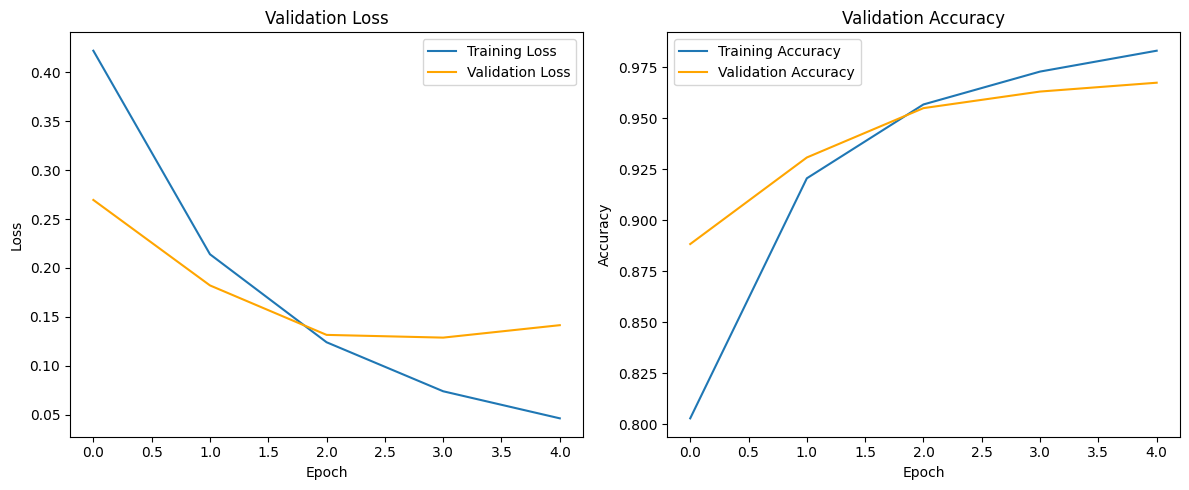

In [ ]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss',color='orange')
ax1.set_title('Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
#evaluating loss and accuray of the model
loss, accuracy = model.evaluate(test_padded,testing_labels_final)
print(f'Accuracy on test dataset :{round(accuracy*100,2)}%')


173/173 [==============================] - 4s 26ms/step - loss: 0.1452 - accuracy: 0.9675
Accuracy on test dataset :96.75%


This code will evaluate the model using the test dataset. It calculates loss and accuracy of the model and then prints the accuracy percentage of the model.

In [ ]:
#predicting the model

pred_prob = model.predict(test_padded)
pred_label = [1 if prob >= 0.5 else 0 for prob in pred_prob]
pred_label[:5]


173/173 [==============================] - 9s 35ms/step


[1, 1, 1, 1, 0]

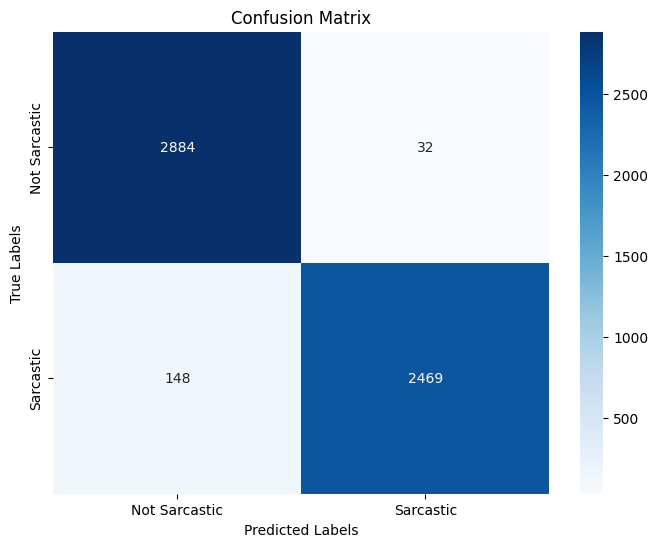

In [ ]:
# Confusion Matrix:

# Compute confusion matrix using the predicted classes and true labels
conf_matrix = confusion_matrix(testing_labels_final, pred_label)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
			xticklabels=['Not Sarcastic', 'Sarcastic'],
			yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Classification Report

# Print Classification Report
print("\nClassification Report:")
print(classification_report(testing_labels_final, pred_label,
							target_names=['Not Sarcastic', 'Sarcastic']))



Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.95      0.99      0.97      2916
    Sarcastic       0.99      0.94      0.96      2617

     accuracy                           0.97      5533
    macro avg       0.97      0.97      0.97      5533
 weighted avg       0.97      0.97      0.97      5533



Predicting if headline is sarcastic or not

In [ ]:
while True:
	# Prompt the user to input a headline or exit
	user_input = input(
		"Enter a headline for prediction (or type 'exit' to quit): ")

	# Check if the user wants to exit
	if user_input.lower() == 'exit':
		break

	# Clean and preprocess user input
	cleaned_input = clean_text(user_input)
	tokenized_input = tokenizer.texts_to_sequences(
		[cleaned_input]) # Tokenize the cleaned text
	padded_input = pad_sequences(
		tokenized_input, maxlen=max_length, padding=padding_type) # Pad the tokenized text

	# Predict sarcasm
	prediction = model.predict(padded_input)

	# Print the prediction result
	if prediction >= 0.5:
		print(f"Headline: {user_input}\nPrediction: Sarcastic")
	else:
		print(f"Headline: {user_input}\nPrediction: Not Sarcastic")


Enter a headline for prediction (or type 'exit' to quit): When something bad happens: “That’s just what I needed today!”
1/1 [==============================] - 0s 34ms/step
Headline: When something bad happens: “That’s just what I needed today!”
Prediction: Sarcastic
Enter a headline for prediction (or type 'exit' to quit): After a long day at work: “I work 40 hours a week for me to be this poor.”
1/1 [==============================] - 0s 73ms/step
Headline: After a long day at work: “I work 40 hours a week for me to be this poor.”
Prediction: Sarcastic
Enter a headline for prediction (or type 'exit' to quit): When something expected occurs: “Well, what a surprise.”
1/1 [==============================] - 0s 31ms/step
Headline: When something expected occurs: “Well, what a surprise.”
Prediction: Sarcastic
Enter a headline for prediction (or type 'exit' to quit): “Well, what a surprise.”
1/1 [==============================] - 0s 35ms/step
Headline: “Well, what a surprise.”
Prediction: No